# REPLICATION

In [ ]:
# Run this cell if the first solution didn't work
# !pip uninstall -y numpy gensim
# !pip install numpy --no-cache-dir
# !pip install gensim --no-cache-dir
# !pip install bertopic

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import re # For regular expressions

# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# For embeddings
from sentence_transformers import SentenceTransformer

# For dimensionality reduction
import umap
from sklearn.decomposition import PCA

# For clustering
import hdbscan
from sklearn.cluster import KMeans

# For TF-IDF and coherence
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Optional: progress bars
from tqdm.auto import tqdm
tqdm.pandas() # For progress_apply

# Configure NLTK (run these downloads once if you haven't already)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
print("Libraries imported and NLTK resources checked/downloaded.")

Libraries imported and NLTK resources checked/downloaded.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
dataset_path = 'dataset.csv'

In [ ]:
df = pd.read_csv(dataset_path)
print("Dataset loaded successfully.")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully.
Dataset shape: (20972, 9)


In [ ]:
if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nMissing values per column:")
    print(df.isnull().sum())


First 5 rows of the dataset:
   ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0       

In [ ]:
# Check if 'TITLE' and 'ABSTRACT' columns exist
if 'df' in locals() and 'TITLE' in df.columns and 'ABSTRACT' in df.columns:
    # Handle potential NaN values in TITLE or ABSTRACT by filling them with empty strings
    df['TITLE'] = df['TITLE'].fillna('')
    df['ABSTRACT'] = df['ABSTRACT'].fillna('')

    # Combine TITLE and ABSTRACT
    df['text'] = df['TITLE'] + " " + df['ABSTRACT']

    print("\n'text' column created by combining 'TITLE' and 'ABSTRACT'.")
    print("First few combined texts:")
    print(df[['TITLE', 'ABSTRACT', 'text']].head())
else:
    print("Error: DataFrame 'df' not loaded or 'TITLE'/'ABSTRACT' columns missing.")
    if 'df' in locals():
        print("Available columns:", df.columns.tolist())


'text' column created by combining 'TITLE' and 'ABSTRACT'.
First few combined texts:
                                               TITLE  \
0        Reconstructing Subject-Specific Effect Maps   
1                 Rotation Invariance Neural Network   
2  Spherical polyharmonics and Poisson kernels fo...   
3  A finite element approximation for the stochas...   
4  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  \
0    Predictive models allow subject-specific inf...   
1    Rotation invariance and translation invarian...   
2    We introduce and develop the notion of spher...   
3    The stochastic Landau--Lifshitz--Gilbert (LL...   
4    Fourier-transform infra-red (FTIR) spectra o...   

                                                text  
0  Reconstructing Subject-Specific Effect Maps   ...  
1  Rotation Invariance Neural Network   Rotation ...  
2  Spherical polyharmonics and Poisson kernels fo...  
3  A finite element 

In [ ]:
# Initialize NLTK tools for preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # Using NLTK's standard English stopword list

def preprocess_text(text):
    # Ensure text is a string
    if not isinstance(text, str):
        text = str(text) # Convert to string if it's not, e.g., if a NaN slipped through

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove hyperlinks (improved regex)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)

    # 3. Remove special characters (keeping only alphanumeric and spaces)
    # This will also remove punctuation.
    text = re.sub(r'[^\w\s]', '', text)

    # 4. Remove numbers / digits
    text = re.sub(r'\d+', '', text)

    # 5. Tokenization
    tokens = word_tokenize(text)

    # 6. Remove stopwords, words of one character, and then lemmatize
    processed_tokens = []
    for word in tokens:
        if word not in stop_words and len(word) > 1:
            # Lemmatize (default POS is noun 'n'. For better accuracy, POS tagging can be added)
            lemmatized_word = lemmatizer.lemmatize(word)
            processed_tokens.append(lemmatized_word)

    return processed_tokens

print("Preprocessing function 'preprocess_text' defined.")

Preprocessing function 'preprocess_text' defined.


In [ ]:
if 'df' in locals() and 'text' in df.columns:
    print("Starting text preprocessing...")
    # Apply the preprocessing function
    # Using progress_apply for a progress bar (ensure tqdm is imported and tqdm.pandas() called)
    df['processed_tokens'] = df['text'].progress_apply(preprocess_text)

    # Create a column with processed text joined back into a string (for sentence transformers)
    df['processed_text_for_bert'] = df['processed_tokens'].progress_apply(lambda tokens: ' '.join(tokens))

    print("\nPreprocessing complete.")
    print("Displaying results for the first few rows:")
    print(df[['text', 'processed_tokens', 'processed_text_for_bert']].head())
else:
    print("Error: DataFrame 'df' not loaded or 'text' column missing.")

# Optional: Check for empty processed texts, which might indicate overly aggressive preprocessing
# or very short/uninformative original texts.
if 'df' in locals() and 'processed_text_for_bert' in df.columns:
    empty_processed_texts = df[df['processed_text_for_bert'] == ''].shape[0]
    if empty_processed_texts > 0:
        print(f"\nWarning: Found {empty_processed_texts} documents with empty text after preprocessing.")
        # Consider how to handle these: remove them, or perhaps they are fine if few.
        # For now, we'll keep them, but sentence transformers might return zero vectors for them.

Starting text preprocessing...


  0%|          | 0/20972 [00:00<?, ?it/s]

  0%|          | 0/20972 [00:00<?, ?it/s]


Preprocessing complete.
Displaying results for the first few rows:
                                                text  \
0  Reconstructing Subject-Specific Effect Maps   ...   
1  Rotation Invariance Neural Network   Rotation ...   
2  Spherical polyharmonics and Poisson kernels fo...   
3  A finite element approximation for the stochas...   
4  Comparative study of Discrete Wavelet Transfor...   

                                    processed_tokens  \
0  [reconstructing, subjectspecific, effect, map,...   
1  [rotation, invariance, neural, network, rotati...   
2  [spherical, polyharmonics, poisson, kernel, po...   
3  [finite, element, approximation, stochastic, m...   
4  [comparative, study, discrete, wavelet, transf...   

                             processed_text_for_bert  
0  reconstructing subjectspecific effect map pred...  
1  rotation invariance neural network rotation in...  
2  spherical polyharmonics poisson kernel polyhar...  
3  finite element approximation stocha

In [ ]:
if 'df' in locals() and 'processed_text_for_bert' in df.columns:
    # --- S-BERT Model Selection ---
    # Using a popular and efficient S-BERT model.
    # If your paper specifies a particular S-BERT model, change 'all-MiniLM-L6-v2' to that model name.
    sbert_model_name = 'all-MiniLM-L6-v2'
    print(f"Loading S-BERT model: {sbert_model_name}")
    sbert_model = SentenceTransformer(sbert_model_name)
    print("S-BERT model loaded.")

    # Prepare the corpus (list of processed text strings)
    corpus_sbert = df['processed_text_for_bert'].tolist()

    # --- Check for and handle empty strings before encoding ---
    # SentenceTransformer might error or produce NaNs for empty strings depending on version
    # A simple way is to replace empty strings with a placeholder like "[UNK]" or a single space
    # or to note their indices and handle them separately after encoding (e.g., assign a zero vector)

    non_empty_corpus_sbert = []
    empty_indices_sbert = []
    for i, text in enumerate(corpus_sbert):
        if text.strip(): # Check if the string is not empty or just whitespace
            non_empty_corpus_sbert.append(text)
        else:
            print(f"Warning: Document at index {i} is empty or whitespace after preprocessing. Will be skipped for S-BERT encoding or handled.")
            non_empty_corpus_sbert.append("[UNK]") # Replace with a placeholder
            # Or, store index to insert a zero vector later: empty_indices_sbert.append(i)

    print(f"\nGenerating S-BERT embeddings for {len(non_empty_corpus_sbert)} documents...")
    # This can take a while depending on dataset size and hardware (GPU helps a lot)
    corpus_embeddings_sbert = sbert_model.encode(non_empty_corpus_sbert, show_progress_bar=True)

    print(f"S-BERT embeddings generated. Shape: {corpus_embeddings_sbert.shape}")
    # The shape should be (number of documents, embedding dimension of the S-BERT model)
    # For 'all-MiniLM-L6-v2', the dimension is 384.

    # If you chose to handle empty strings by inserting zero vectors later:
    # final_embeddings_sbert = np.zeros((len(corpus_sbert), corpus_embeddings_sbert.shape[1]))
    # current_non_empty_idx = 0
    # for i in range(len(corpus_sbert)):
    #     if i not in empty_indices_sbert:
    #         final_embeddings_sbert[i] = corpus_embeddings_sbert[current_non_empty_idx]
    #         current_non_empty_idx += 1
    # corpus_embeddings_sbert = final_embeddings_sbert # Overwrite with the full-sized array

else:
    print("Error: DataFrame 'df' not loaded or 'processed_text_for_bert' column missing.")
    # Define a placeholder if previous steps failed, to allow subsequent cells to run for structure
    corpus_embeddings_sbert = np.random.rand(df.shape[0] if 'df' in locals() else 3, 384)
    print(f"Using placeholder S-BERT embeddings. Shape: {corpus_embeddings_sbert.shape}")

Loading S-BERT model: all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

S-BERT model loaded.

Generating S-BERT embeddings for 20972 documents...


Batches:   0%|          | 0/656 [00:00<?, ?it/s]

S-BERT embeddings generated. Shape: (20972, 384)


In [ ]:
if 'corpus_embeddings_sbert' in locals() and corpus_embeddings_sbert.size > 0 :
    # --- UMAP Hyperparameters ---
    # These are critical. Try to match the paper or use common BERTopic defaults.
    # The paper's Table IV implies UMAP was used. Specific params might be in the text.
    n_neighbors_umap = 15      # Default: 15. Affects local vs. global structure.
    n_components_umap_sbert = 5 # Default: 2 for viz, but for BERTopic often 5 or higher.
                                # The paper's score of 0.4857 might be based on a low n_components.
                                # If results are poor, try increasing this (e.g., 10, 20, 50).
    min_dist_umap = 0.0        # Default: 0.1. Controls how tightly UMAP packs points.
    metric_umap = 'cosine'     # Suitable for S-BERT embeddings.
    random_state_umap = 42     # For reproducibility.

    print(f"Performing UMAP dimensionality reduction on S-BERT embeddings...")
    print(f"Parameters: n_neighbors={n_neighbors_umap}, n_components={n_components_umap_sbert}, min_dist={min_dist_umap}, metric='{metric_umap}'")

    reducer_umap_sbert = umap.UMAP(
        n_neighbors=n_neighbors_umap,
        n_components=n_components_umap_sbert,
        min_dist=min_dist_umap,
        metric=metric_umap,
        random_state=random_state_umap,
        low_memory=False # Set to True if you have memory issues, might be slower
    )

    reduced_embeddings_umap_sbert = reducer_umap_sbert.fit_transform(corpus_embeddings_sbert)

    print(f"UMAP reduction complete for S-BERT. Shape of reduced embeddings: {reduced_embeddings_umap_sbert.shape}")
    # Shape should be (number of documents, n_components_umap_sbert)
else:
    print("Error: S-BERT embeddings ('corpus_embeddings_sbert') not available or empty.")
    # Define a placeholder if previous steps failed
    reduced_embeddings_umap_sbert = np.random.rand(df.shape[0] if 'df' in locals() else 3, 5)
    print(f"Using placeholder UMAP-reduced S-BERT embeddings. Shape: {reduced_embeddings_umap_sbert.shape}")

Performing UMAP dimensionality reduction on S-BERT embeddings...
Parameters: n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduction complete for S-BERT. Shape of reduced embeddings: (20972, 5)


In [ ]:
if 'reduced_embeddings_umap_sbert' in locals() and reduced_embeddings_umap_sbert.size > 0:
    # --- HDBSCAN Hyperparameters ---
    # These significantly affect clustering. Try to match paper or BERTopic defaults.
    min_cluster_size_hdbscan = 15 # Example: Default in BERTopic is often 10 or 15. Adjust based on dataset/expected topics.
    min_samples_hdbscan = None    # Example: If None, defaults to min_cluster_size. Can be set explicitly.
    metric_hdbscan = 'euclidean'  # Standard for UMAP output.
    # Other params: cluster_selection_epsilon, alpha, etc. can be tuned.

    print(f"Performing HDBSCAN clustering...")
    print(f"Parameters: min_cluster_size={min_cluster_size_hdbscan}, min_samples={min_samples_hdbscan}, metric='{metric_hdbscan}'")

    clusterer_hdbscan = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size_hdbscan,
        min_samples=min_samples_hdbscan,
        metric=metric_hdbscan,
        gen_min_span_tree=True, # Useful for some advanced analysis, not strictly necessary for labels
        allow_single_cluster=False # Default is False, set to True if you might expect only one dominant topic
    )

    # Ensure the input is C-contiguous, which HDBSCAN expects for some metrics/algorithms
    # UMAP output is usually fine, but this is a good practice.
    contiguous_reduced_embeddings_umap_sbert = np.ascontiguousarray(reduced_embeddings_umap_sbert)

    cluster_labels_hdbscan = clusterer_hdbscan.fit_predict(contiguous_reduced_embeddings_umap_sbert)

    # Add cluster labels to the DataFrame
    if 'df' in locals():
        df['hdbscan_sbert_umap_cluster'] = cluster_labels_hdbscan

        num_clusters_found = len(set(cluster_labels_hdbscan)) - (1 if -1 in cluster_labels_hdbscan else 0)
        num_noise_points = np.sum(cluster_labels_hdbscan == -1)

        print(f"HDBSCAN clustering complete.")
        print(f"Number of clusters found (excluding noise): {num_clusters_found}")
        print(f"Number of noise points (-1): {num_noise_points} ({(num_noise_points/len(cluster_labels_hdbscan)*100):.2f}%)")
        print("\nCluster label distribution:")
        print(pd.Series(cluster_labels_hdbscan).value_counts())
    else:
        print("HDBSCAN clustering complete, but DataFrame 'df' not found to store labels.")

else:
    print("Error: UMAP-reduced S-BERT embeddings not available or empty.")
    if 'df' in locals():
        df['hdbscan_sbert_umap_cluster'] = -1 # Placeholder
        print("Assigned placeholder HDBSCAN clusters.")

Performing HDBSCAN clustering...
Parameters: min_cluster_size=15, min_samples=None, metric='euclidean'


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clustering complete.
Number of clusters found (excluding noise): 171
Number of noise points (-1): 8226 (39.22%)

Cluster label distribution:
-1      8226
 147     575
 16      519
 52      441
 117     379
        ... 
 43       16
 83       15
 132      15
 64       15
 152      15
Name: count, Length: 172, dtype: int64


In [ ]:
if 'df' in locals() and 'processed_text_for_bert' in df.columns:
    # --- RoBERTa Model Selection ---
    # Using 'roberta-base' as a common RoBERTa model accessible via sentence-transformers.
    # If your paper specifies a different RoBERTa model, change this.
    roberta_model_name = 'stsb-roberta-base-v2'
    # Other options could be 'stsb-roberta-base', 'roberta-large', etc.
    # Note: Some RoBERTa models might not be directly available as sentence-transformers
    # and might require using Hugging Face's `transformers` library with mean pooling.
    # For simplicity, we'll assume a sentence-transformer compatible RoBERTa model.

    print(f"Loading RoBERTa model: {roberta_model_name}")
    try:
        roberta_model = SentenceTransformer(roberta_model_name)
        print("RoBERTa model loaded.")

        # Prepare the corpus (list of processed text strings) - same as for S-BERT
        corpus_roberta = df['processed_text_for_bert'].tolist() # Re-using the same processed text

        # --- Handle empty strings before encoding (similar to S-BERT) ---
        non_empty_corpus_roberta = []
        # empty_indices_roberta = [] # If you want to track them separately
        for i, text in enumerate(corpus_roberta):
            if text.strip():
                non_empty_corpus_roberta.append(text)
            else:
                print(f"Warning: Document at index {i} is empty or whitespace. Will be skipped/handled for RoBERTa encoding.")
                non_empty_corpus_roberta.append("[UNK]") # Placeholder
                # empty_indices_roberta.append(i)

        print(f"\nGenerating RoBERTa embeddings for {len(non_empty_corpus_roberta)} documents...")
        corpus_embeddings_roberta = roberta_model.encode(non_empty_corpus_roberta, show_progress_bar=True)

        print(f"RoBERTa embeddings generated. Shape: {corpus_embeddings_roberta.shape}")
        # The shape should be (number of documents, embedding dimension of the RoBERTa model)
        # For 'roberta-base', this is 768.

    except Exception as e:
        print(f"Error loading or using RoBERTa model '{roberta_model_name}': {e}")
        print("Ensure the model name is correct and accessible via sentence-transformers.")
        print("If using a raw Hugging Face RoBERTa model, manual pooling might be needed.")
        corpus_embeddings_roberta = np.random.rand(df.shape[0] if 'df' in locals() else 3, 768) # Placeholder
        print(f"Using placeholder RoBERTa embeddings. Shape: {corpus_embeddings_roberta.shape}")

else:
    print("Error: DataFrame 'df' not loaded or 'processed_text_for_bert' column missing.")
    corpus_embeddings_roberta = np.random.rand(df.shape[0] if 'df' in locals() else 3, 768) # Placeholder
    print(f"Using placeholder RoBERTa embeddings. Shape: {corpus_embeddings_roberta.shape}")

Loading RoBERTa model: stsb-roberta-base-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

RoBERTa model loaded.

Generating RoBERTa embeddings for 20972 documents...


Batches:   0%|          | 0/656 [00:00<?, ?it/s]

RoBERTa embeddings generated. Shape: (20972, 768)


In [ ]:
# Cell 10 (Modified for this iteration)
if 'corpus_embeddings_roberta' in locals() and corpus_embeddings_roberta.size > 0:
    # --- PCA Hyperparameters ---
    n_components_pca_roberta = 50
    random_state_pca = 42

    print(f"Performing PCA dimensionality reduction on RoBERTa embeddings...")
    print(f"Parameters: n_components={n_components_pca_roberta}")

    pca_roberta = PCA(
        n_components=n_components_pca_roberta,
        random_state=random_state_pca
    )

    reduced_embeddings_pca_roberta = pca_roberta.fit_transform(corpus_embeddings_roberta)

    explained_variance_ratio_sum = pca_roberta.explained_variance_ratio_.sum()
    print(f"PCA reduction complete for RoBERTa. Shape of reduced embeddings: {reduced_embeddings_pca_roberta.shape}")
    print(f"Total explained variance by {n_components_pca_roberta} components: {explained_variance_ratio_sum:.4f}")

else:
    print("Error: RoBERTa embeddings ('corpus_embeddings_roberta') not available or empty.")
    # Adjust placeholder if needed for testing structure, though actual embeddings are crucial
    reduced_embeddings_pca_roberta = np.random.rand(df.shape[0] if 'df' in locals() else 3, 150)
    print(f"Using placeholder PCA-reduced RoBERTa embeddings. Shape: {reduced_embeddings_pca_roberta.shape}")

Performing PCA dimensionality reduction on RoBERTa embeddings...
Parameters: n_components=50
PCA reduction complete for RoBERTa. Shape of reduced embeddings: (20972, 50)
Total explained variance by 50 components: 0.7184


In [ ]:
if 'reduced_embeddings_pca_roberta' in locals() and reduced_embeddings_pca_roberta.size > 0:
    # --- K-Means Hyperparameters ---
    # 'n_clusters' (K) is crucial. The paper states 6 ground truth topics.
    # This is a strong candidate for K.
    n_clusters_kmeans = 6         # Based on the 6 topics mentioned in the dataset description.
    random_state_kmeans = 42      # For reproducibility.
    # n_init='auto' in newer scikit-learn versions, or explicitly set to 10.
    # If you have scikit-learn < 1.2, use n_init=10. For >=1.2, 'auto' is fine.
    # Check your scikit-learn version: import sklearn; print(sklearn.__version__)
    try: # Handle n_init='auto' for newer scikit-learn
        kmeans_roberta = KMeans(
            n_clusters=n_clusters_kmeans,
            random_state=random_state_kmeans,
            n_init='auto'
        )
    except TypeError: # Fallback for older scikit-learn
         kmeans_roberta = KMeans(
            n_clusters=n_clusters_kmeans,
            random_state=random_state_kmeans,
            n_init=10
        )

    print(f"Performing K-Means clustering...")
    print(f"Parameters: n_clusters={n_clusters_kmeans}")

    cluster_labels_kmeans_roberta = kmeans_roberta.fit_predict(reduced_embeddings_pca_roberta)

    # Add cluster labels to the DataFrame
    if 'df' in locals():
        df['kmeans_roberta_pca_cluster'] = cluster_labels_kmeans_roberta

        print(f"K-Means clustering complete.")
        print(f"Number of clusters specified: {n_clusters_kmeans}")
        print("\nCluster label distribution:")
        print(pd.Series(cluster_labels_kmeans_roberta).value_counts().sort_index())
    else:
        print("K-Means clustering complete, but DataFrame 'df' not found to store labels.")

else:
    print("Error: PCA-reduced RoBERTa embeddings not available or empty.")
    if 'df' in locals():
        df['kmeans_roberta_pca_cluster'] = 0 # Placeholder
        print("Assigned placeholder K-Means clusters.")

Performing K-Means clustering...
Parameters: n_clusters=6
K-Means clustering complete.
Number of clusters specified: 6

Cluster label distribution:
0    3661
1    4135
2    3846
3    3345
4    1659
5    4326
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # TfidfTransformer for custom IDF if needed

def get_ctfidf_topic_words(
    cluster_labels: pd.Series,
    documents: list[str],
    top_n_words: int = 10,
    custom_stopwords: list[str] = None
) -> tuple[list[list[str]], list[int]]:
    """
    Calculates c-TF-IDF scores and extracts top words for each topic (cluster).

    Args:
        cluster_labels (pd.Series): Series containing cluster labels for each document.
        documents (list[str]): List of preprocessed documents (as single strings).
        top_n_words (int): Number of top words to extract for each topic.
        custom_stopwords (list[str], optional): A list of custom stopwords to use.
                                                Defaults to NLTK English stopwords if None.

    Returns:
        tuple[list[list[str]], list[int]]:
            - A list where each inner list contains the top_n_words for a valid topic.
            - A list of the topic IDs (cluster labels) corresponding to the topic words.
    """
    if custom_stopwords is None:
        # Use a default if none provided, or consider passing NLTK's list
        current_stopwords = list(stopwords.words('english'))
    else:
        current_stopwords = custom_stopwords

    docs_df = pd.DataFrame({
        "Doc": documents,
        "Topic": cluster_labels
    })

    # Aggregate documents per topic
    # Important: Ensure documents are joined with spaces, not concatenated without them
    docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})

    # Filter out noise topic (commonly -1 for HDBSCAN)
    # Also filter out any topics that might have resulted in empty aggregated documents
    docs_per_topic = docs_per_topic[docs_per_topic.Topic != -1]
    docs_per_topic = docs_per_topic[docs_per_topic.Doc.str.strip() != '']

    if docs_per_topic.empty:
        print("Warning: No valid topics found after filtering noise or empty aggregated docs.")
        return [], []

    # --- c-TF-IDF Calculation ---
    # 1. Calculate term frequencies (TF) per topic-document
    count_vectorizer = CountVectorizer(stop_words=current_stopwords, ngram_range=(1,1)) # Consider ngram_range from paper
    tf_matrix = count_vectorizer.fit_transform(docs_per_topic.Doc)
    words = count_vectorizer.get_feature_names_out()

    # 2. Calculate inverse document frequency (IDF)
    # IDF = log( (total number of documents / number of documents containing term) + 1 )
    # In c-TF-IDF, "total number of documents" is the total number of original documents (len(documents))
    # "number of documents containing term" for IDF means number of *topics* term appears in, if using topic-docs.
    # BERTopic's c-TF-IDF: IDF is calculated across all words in all documents, then weighted by TF per class.
    # A simpler variant: TfidfTransformer on the class-concatenated documents.

    # Option A: Scikit-learn's TfidfTransformer (treats each topic as a document)
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_matrix = tfidf_transformer.fit_transform(tf_matrix)

    # Option B: More direct BERTopic-like c-TF-IDF (TF * Average IDF)
    # This is a bit more involved. For simplicity, Option A is often sufficient as a proxy.
    # If precise replication of BERTopic's c-TF-IDF is needed, its source code is the best reference.
    # We'll proceed with Option A for now.

    ctfidf_scores = tfidf_matrix.toarray()

    topic_top_words_list = []
    valid_topic_ids = docs_per_topic.Topic.tolist()

    for i, topic_id in enumerate(valid_topic_ids):
        # Get scores for the current topic (row in ctfidf_scores)
        topic_scores = ctfidf_scores[i, :]
        # Get indices of top N words
        top_word_indices = topic_scores.argsort()[-top_n_words:][::-1]
        # Get the actual words
        topic_keywords = [words[idx] for idx in top_word_indices if topic_scores[idx] > 0] # Ensure score > 0
        if topic_keywords: # Only add if there are keywords
             topic_top_words_list.append(topic_keywords)
        else:
            # If a topic has no keywords (e.g., all words were stopwords or scores were zero)
            # it might be better to remove this topic_id from valid_topic_ids
            print(f"Warning: Topic {topic_id} resulted in no keywords after c-TF-IDF.")
            # This can happen if a cluster is very small or its documents are all stopwords after processing

    # Filter valid_topic_ids if some topics had no keywords
    final_valid_topic_ids = [tid for i, tid in enumerate(valid_topic_ids) if i < len(topic_top_words_list)]

    return topic_top_words_list, final_valid_topic_ids


print("c-TF-IDF function 'get_ctfidf_topic_words' defined.")

c-TF-IDF function 'get_ctfidf_topic_words' defined.


In [ ]:
if 'df' in locals() and 'processed_tokens' in df.columns and 'hdbscan_sbert_umap_cluster' in df.columns:
    all_processed_tokens = df['processed_tokens'].tolist() # List of lists of tokens

    # Ensure all_processed_tokens does not contain empty lists, which Gensim dictionary might not like
    # Or that CoherenceModel can handle them if texts parameter is used.
    # Gensim Dictionary will filter out empty lists of tokens by default.
    if not any(all_processed_tokens): # check if all sublists are empty or the main list is empty
        print("Error: 'all_processed_tokens' is empty or contains only empty lists. Cannot create dictionary.")
    else:
        print("Creating Gensim dictionary...")
        try:
            gensim_dictionary = Dictionary(all_processed_tokens)
            # Optional: Filter extremes (though your preprocessing should handle much of this)
            # gensim_dictionary.filter_extremes(no_below=5, no_above=0.5)
            print(f"Gensim dictionary created. Vocabulary size: {len(gensim_dictionary)}")

            # --- Extract Topic Words for Pipeline 1 (HDBSCAN-SBert-UMAP) ---
            print("\nExtracting topic words for Pipeline 1 (HDBSCAN-SBert-UMAP)...")
            # Using df['processed_text_for_bert'] which are strings of joined tokens
            # This is what c-TF-IDF usually expects as input documents for vectorization.
            # The NLTK stopword list might be slightly different from what BERTopic uses internally if it has one.
            # Paper mentions NLTK stopwords in preprocessing.

            # Using the actual 'processed_text_for_bert' for c-TF-IDF doc input
            docs_as_strings_for_ctfidf = df['processed_text_for_bert'].tolist()

            # Ensure custom_stopwords in get_ctfidf_topic_words aligns with initial preprocessing stopword list
            nltk_stopwords_list = list(stopwords.words('english'))

            topics_hdbscan, valid_hdbscan_topic_ids = get_ctfidf_topic_words(
                cluster_labels=df['hdbscan_sbert_umap_cluster'],
                documents=docs_as_strings_for_ctfidf,
                top_n_words=10, # Standard number of words for coherence
                custom_stopwords=nltk_stopwords_list
            )

            if topics_hdbscan:
                print(f"Found {len(topics_hdbscan)} topics for HDBSCAN pipeline.")
                # print("Top words for HDBSCAN topics (first 3 topics):")
                # for i, topic in enumerate(topics_hdbscan[:3]):
                #     print(f"Topic {valid_hdbscan_topic_ids[i]}: {topic}")

                # --- Calculate C_v Coherence for Pipeline 1 ---
                # `texts` parameter for CoherenceModel should be the tokenized documents (list of lists of strings)
                cm_hdbscan = CoherenceModel(
                    topics=topics_hdbscan,
                    texts=all_processed_tokens,
                    dictionary=gensim_dictionary,
                    coherence='c_v'
                )
                coherence_cv_hdbscan = cm_hdbscan.get_coherence()
                print(f"\n>>> Pipeline 1 (HDBSCAN-SBert-UMAP) C_v Coherence: {coherence_cv_hdbscan:.4f}")
                # Target from paper: 0.4857
            else:
                print("Pipeline 1 (HDBSCAN-SBert-UMAP): No valid topics found to calculate coherence.")
                coherence_cv_hdbscan = "N/A"

        except Exception as e:
            print(f"An error occurred during Gensim dictionary creation or coherence calculation for Pipeline 1: {e}")
            coherence_cv_hdbscan = "Error"
else:
    print("Error: Prerequisite data for Pipeline 1 coherence calculation is missing.")
    coherence_cv_hdbscan = "Skipped"

Creating Gensim dictionary...
Gensim dictionary created. Vocabulary size: 81394

Extracting topic words for Pipeline 1 (HDBSCAN-SBert-UMAP)...
Found 171 topics for HDBSCAN pipeline.

>>> Pipeline 1 (HDBSCAN-SBert-UMAP) C_v Coherence: 0.6236


In [ ]:
if 'df' in locals() and 'processed_tokens' in df.columns and 'kmeans_roberta_pca_cluster' in df.columns and 'gensim_dictionary' in globals():
    # --- Extract Topic Words for Pipeline 2 (KMeans-RoBERTa-PCA) ---
    print("\nExtracting topic words for Pipeline 2 (KMeans-RoBERTa-PCA)...")

    # Re-using docs_as_strings_for_ctfidf and nltk_stopwords_list from above

    topics_kmeans, valid_kmeans_topic_ids = get_ctfidf_topic_words(
        cluster_labels=df['kmeans_roberta_pca_cluster'],
        documents=docs_as_strings_for_ctfidf, # df['processed_text_for_bert'].tolist()
        top_n_words=10,
        custom_stopwords=nltk_stopwords_list
    )

    if topics_kmeans:
        print(f"Found {len(topics_kmeans)} topics for K-Means pipeline.")
        # print("Top words for K-Means topics (first 3 topics):")
        # for i, topic in enumerate(topics_kmeans[:3]):
        #     print(f"Topic {valid_kmeans_topic_ids[i]}: {topic}")

        # --- Calculate C_v Coherence for Pipeline 2 ---
        cm_kmeans = CoherenceModel(
            topics=topics_kmeans,
            texts=all_processed_tokens,
            dictionary=gensim_dictionary,
            coherence='c_v'
        )
        coherence_cv_kmeans = cm_kmeans.get_coherence()
        print(f"\n>>> Pipeline 2 (KMeans-RoBERTa-PCA) C_v Coherence: {coherence_cv_kmeans:.4f}")
        # Target from paper: 0.5554
    else:
        print("Pipeline 2 (KMeans-RoBERTa-PCA): No valid topics found to calculate coherence.")
        coherence_cv_kmeans = "N/A"

else:
    print("Error: Prerequisite data for Pipeline 2 coherence calculation is missing or Gensim dictionary not created.")
    coherence_cv_kmeans = "Skipped"


Extracting topic words for Pipeline 2 (KMeans-RoBERTa-PCA)...
Found 6 topics for K-Means pipeline.

>>> Pipeline 2 (KMeans-RoBERTa-PCA) C_v Coherence: 0.4756


In [ ]:
print("\n--- Final Coherence Score Summary ---")
print(f"Pipeline 1 (HDBSCAN-SBert-UMAP) Target C_v: 0.4857")
print(f"Pipeline 1 (HDBSCAN-SBert-UMAP) Achieved C_v: {coherence_cv_hdbscan}")

print(f"\nPipeline 2 (KMeans-RoBERTa-PCA) Target C_v: 0.5554")
print(f"Pipeline 2 (KMeans-RoBERTa-PCA) Achieved C_v: {coherence_cv_kmeans}")

# You can also display UMass if you implement its calculation,
# but C_v is your primary target for replication based on the scores you mentioned.


--- Final Coherence Score Summary ---
Pipeline 1 (HDBSCAN-SBert-UMAP) Target C_v: 0.4857
Pipeline 1 (HDBSCAN-SBert-UMAP) Achieved C_v: 0.6236491889820511

Pipeline 2 (KMeans-RoBERTa-PCA) Target C_v: 0.5554
Pipeline 2 (KMeans-RoBERTa-PCA) Achieved C_v: 0.47563434745768457


In [ ]:
# Ensure 'topics_hdbscan' and 'valid_hdbscan_topic_ids' are from the chosen configuration for Pipeline 1
# These should have been generated and stored when you last ran Cell 13 with the desired settings.

print("\n--- Top Words for Pipeline 1 (HDBSCAN-SBert-UMAP) Topics ---")
if 'topics_hdbscan' in globals() and 'valid_hdbscan_topic_ids' in globals() and topics_hdbscan:
    print(f"Number of topics found (excluding noise): {len(topics_hdbscan)}")

    # Get document counts for each topic
    if 'df' in locals() and 'hdbscan_sbert_umap_cluster' in df.columns:
        topic_counts_hdbscan = df[df['hdbscan_sbert_umap_cluster'] != -1]['hdbscan_sbert_umap_cluster'].value_counts().sort_index()
    else:
        topic_counts_hdbscan = None

    for i, topic_words in enumerate(topics_hdbscan):
        topic_id = valid_hdbscan_topic_ids[i]
        count_str = f"(Docs: {topic_counts_hdbscan.get(topic_id, 'N/A')})" if topic_counts_hdbscan is not None else ""
        print(f"Topic {topic_id} {count_str}: {', '.join(topic_words)}")
        if i >= 19 and len(topics_hdbscan) > 20 : # Print first 20 topics if many
            print("... (and so on for other topics)")
            break
else:
    print("Topic words for Pipeline 1 not available. Please ensure Cell 13 has been run with desired settings.")


--- Top Words for Pipeline 1 (HDBSCAN-SBert-UMAP) Topics ---
Number of topics found (excluding noise): 171
Topic 0 (Docs: 39): fairness, fair, learning, unfairness, decision, discrimination, disparity, machine, bias, data
Topic 1 (Docs: 20): packing, knapsack, problem, item, fptas, bin, lws, algorithm, pack, approximation
Topic 2 (Docs: 86): epidemic, disease, infection, model, outbreak, infectious, contagion, infected, network, vaccination
Topic 3 (Docs: 24): distributed, sgd, gradient, algorithm, communication, worker, optimization, learning, straggler, adfs
Topic 4 (Docs: 48): agent, distributed, consensus, algorithm, communication, network, problem, node, optimization, multiagent
Topic 5 (Docs: 146): adversarial, attack, network, learning, classifier, model, neural, deep, example, training
Topic 6 (Docs: 25): seismic, earthquake, seismicity, tectonic, model, ndsha, plate, data, event, slip
Topic 7 (Docs: 22): sensor, gait, gesture, wearable, adl, data, recognition, activity, accel

In [ ]:
# Ensure 'topics_kmeans' and 'valid_kmeans_topic_ids' are from the chosen configuration for Pipeline 2
# These should have been generated and stored when you last ran Cell 14 with the desired settings.

print("\n--- Top Words for Pipeline 2 (KMeans-RoBERTa-PCA) Topics ---")
if 'topics_kmeans' in globals() and 'valid_kmeans_topic_ids' in globals() and topics_kmeans:
    print(f"Number of topics found: {len(topics_kmeans)}")

    # Get document counts for each topic
    if 'df' in locals() and 'kmeans_roberta_pca_cluster' in df.columns:
        topic_counts_kmeans = df['kmeans_roberta_pca_cluster'].value_counts().sort_index()
    else:
        topic_counts_kmeans = None

    for i, topic_words in enumerate(topics_kmeans):
        topic_id = valid_kmeans_topic_ids[i] # K-Means topics are usually 0 to K-1
        count_str = f"(Docs: {topic_counts_kmeans.get(topic_id, 'N/A')})" if topic_counts_kmeans is not None else ""
        print(f"Topic {topic_id} {count_str}: {', '.join(topic_words)}")
else:
    print("Topic words for Pipeline 2 not available. Please ensure Cell 14 has been run with desired settings.")


--- Top Words for Pipeline 2 (KMeans-RoBERTa-PCA) Topics ---
Number of topics found: 6
Topic 0 (Docs: 3661): network, data, system, model, paper, using, method, approach, result, time
Topic 1 (Docs: 4135): model, method, algorithm, data, problem, approach, result, show, using, function
Topic 2 (Docs: 3846): system, model, state, field, energy, phase, magnetic, quantum, result, show
Topic 3 (Docs: 3345): network, learning, model, neural, method, data, deep, approach, training, algorithm
Topic 4 (Docs: 1659): galaxy, star, model, mass, data, using, result, system, stellar, observation
Topic 5 (Docs: 4326): group, result, function, problem, space, show, paper, also, set, graph


# TRYING ANOTHER MODEL TO OUTSTAND THE 2 PIPELINE BEFORE

In [ ]:
# !pip install bertopic

In [ ]:
# Cell for Pipeline 3 Setup
# Ensure bertopic is installed: pip install bertopic

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer # Already imported, but good to note dependency

# We will reuse:
# - df['processed_text_for_bert'] for input documents to BERTopic
# - all_processed_tokens (list of lists of tokens from your initial preprocessing) for C_v
# - gensim_dictionary (from your initial preprocessing) for C_v
# - get_ctfidf_topic_words (your function from Cell 12, if BERTopic's default topic words don't work well with Gensim's CoherenceModel or if you want consistency)
#   However, BERTopic has its own get_topic_info() and get_topic() which are usually preferred.

print("BERTopic imported.")

BERTopic imported.


In [ ]:
# Cell for Pipeline 3: BERTopic Implementation (Modified for ngrams)

if 'df' in locals() and 'processed_text_for_bert' in df.columns:
    docs_for_bertopic = df['processed_text_for_bert'].tolist()

    embedding_model_for_bertopic = 'all-mpnet-base-v2'
    bertopic_min_topic_size = 40 # Keep this constant for now to isolate ngram effect

    from sklearn.feature_extraction.text import CountVectorizer
    nltk_stopwords_list = list(stopwords.words('english'))
    vectorizer_model = CountVectorizer(stop_words=nltk_stopwords_list,
                                       ngram_range=(1, 1))

    print(f"Initializing BERTopic with embedding_model='{embedding_model_for_bertopic}', min_topic_size = {bertopic_min_topic_size} and ngram_range=(1,1)")
    pipeline3_topic_model = BERTopic(
        embedding_model=embedding_model_for_bertopic,
        min_topic_size=bertopic_min_topic_size,
        vectorizer_model=vectorizer_model,
        verbose=True,
        calculate_probabilities=False
    )

    print("Fitting BERTopic model...")
    topics_p3, probabilities_p3 = pipeline3_topic_model.fit_transform(docs_for_bertopic)

    df['bertopic_pipeline3_cluster'] = topics_p3

    print("BERTopic model fitting complete.")

    topic_info_p3 = pipeline3_topic_model.get_topic_info()
    print("\nBERTopic Topic Info (first few topics):")
    print(topic_info_p3.head())

    num_bertopic_topics_found = len(topic_info_p3[topic_info_p3.Topic != -1])
    print(f"\nNumber of topics found by BERTopic (excluding -1 outlier topic): {num_bertopic_topics_found}")

    p3_topic_words_for_coherence = []
    valid_topic_ids_p3 = []

    for topic_id_row in topic_info_p3["Topic"]:
        current_topic_id = int(topic_id_row)
        if current_topic_id == -1:
            continue

        topic_terms = pipeline3_topic_model.get_topic(current_topic_id)
        if topic_terms:
            p3_topic_words_for_coherence.append([term for term, score in topic_terms[:10]])
            valid_topic_ids_p3.append(current_topic_id)

    if not p3_topic_words_for_coherence:
        print("Warning: No valid topic words extracted from BERTopic for coherence calculation.")

else:
    print("Error: DataFrame 'df' or 'processed_text_for_bert' column not available.")
    p3_topic_words_for_coherence = []
    num_bertopic_topics_found = 0

2025-11-17 08:36:07,918 - BERTopic - Embedding - Transforming documents to embeddings.


Initializing BERTopic with embedding_model='all-mpnet-base-v2', min_topic_size = 40 and ngram_range=(1,1)
Fitting BERTopic model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/656 [00:00<?, ?it/s]

2025-11-17 08:40:19,321 - BERTopic - Embedding - Completed ✓
2025-11-17 08:40:19,322 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 08:40:38,796 - BERTopic - Dimensionality - Completed ✓
2025-11-17 08:40:38,799 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 08:40:43,924 - BERTopic - Cluster - Completed ✓
2025-11-17 08:40:43,932 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 08:40:45,740 - BERTopic - Representation - Completed ✓


BERTopic model fitting complete.

BERTopic Topic Info (first few topics):
   Topic  Count                                            Name  \
0     -1   9442                     -1_model_system_data_method   
1      0    608  0_estimator_distribution_regression_estimation   
2      1    456                      1_galaxy_star_cluster_mass   
3      2    403           2_robot_policy_reinforcement_learning   
4      3    385                  3_neural_network_deep_training   

                                      Representation  \
0  [model, system, data, method, problem, result,...   
1  [estimator, distribution, regression, estimati...   
2  [galaxy, star, cluster, mass, stellar, halo, r...   
3  [robot, policy, reinforcement, learning, task,...   
4  [neural, network, deep, training, learning, la...   

                                 Representative_Docs  
0  [towards arbitrary noise augmentation deep lea...  
1  [weighted batch mean estimator markov chain mo...  
2  [evolutionary phas

In [ ]:
# Cell for Pipeline 3: Coherence Calculation for BERTopic

coherence_cv_pipeline3 = "N/A" # Default if calculation fails

if 'p3_topic_words_for_coherence' in globals() and p3_topic_words_for_coherence:
    if 'all_processed_tokens' in globals() and 'gensim_dictionary' in globals():
        print(f"Calculating C_v coherence for {len(p3_topic_words_for_coherence)} BERTopic topics...")

        cm_pipeline3 = CoherenceModel(
            topics=p3_topic_words_for_coherence,
            texts=all_processed_tokens,       # Your original tokenized texts
            dictionary=gensim_dictionary,     # Your Gensim dictionary
            coherence='c_v'
        )
        coherence_cv_pipeline3 = cm_pipeline3.get_coherence()
        print(f"\n>>> Pipeline 3 (BERTopic) C_v Coherence: {coherence_cv_pipeline3:.4f}")
    else:
        print("Error: 'all_processed_tokens' or 'gensim_dictionary' not found. Cannot calculate coherence.")
elif 'num_bertopic_topics_found' in globals() and num_bertopic_topics_found == 0:
     print("Pipeline 3 (BERTopic): No topics were found by BERTopic (excluding outliers). Cannot calculate coherence.")
else:
    print("Error: Topic words for Pipeline 3 (BERTopic) are not available. Cannot calculate coherence.")


Calculating C_v coherence for 84 BERTopic topics...

>>> Pipeline 3 (BERTopic) C_v Coherence: 0.6843


In [ ]:
# Update the summary (assuming Cell 15 is your summary cell)
# You might want to add this to Cell 15 or print a new summary here.
print("\n--- Updated Coherence Score Summary ---")
if 'coherence_cv_hdbscan' in globals(): # From Pipeline 1
    print(f"Pipeline 1 (HDBSCAN-SBert-UMAP) Target C_v: 0.4857 | Achieved C_v: {coherence_cv_hdbscan}")
if 'coherence_cv_kmeans' in globals(): # From Pipeline 2
    print(f"Pipeline 2 (KMeans-RoBERTa-PCA) Target C_v: 0.5554 | Achieved C_v: {coherence_cv_kmeans}")
print(f"Pipeline 3 (BERTopic with min_topic_size={bertopic_min_topic_size if 'bertopic_min_topic_size' in globals() else 'N/A'}) Achieved C_v: {coherence_cv_pipeline3}")
if 'num_bertopic_topics_found' in globals():
    print(f"Pipeline 3 (BERTopic) Number of Topics: {num_bertopic_topics_found}")


--- Updated Coherence Score Summary ---
Pipeline 1 (HDBSCAN-SBert-UMAP) Target C_v: 0.4857 | Achieved C_v: 0.6236491889820511
Pipeline 2 (KMeans-RoBERTa-PCA) Target C_v: 0.5554 | Achieved C_v: 0.47563434745768457
Pipeline 3 (BERTopic with min_topic_size=40) Achieved C_v: 0.6842642694147633
Pipeline 3 (BERTopic) Number of Topics: 84


In [ ]:
# Cell for Pipeline 3 Improvements (BERTopic)

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP # For UMAP parameter tuning
import nltk
from nltk.corpus import stopwords
from gensim.models.coherencemodel import CoherenceModel # For coherence calculation

# Ensure stopwords are available
try:
    nltk_stopwords_list = list(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    nltk_stopwords_list = list(stopwords.words('english'))

# --- Shared Setup ---
if 'df' in locals() and 'processed_text_for_bert' in df.columns:
    docs_for_bertopic_improved = df['processed_text_for_bert'].tolist()
    embedding_model_bt_improved = 'all-mpnet-base-v2' # Keep consistent for now
    initial_min_topic_size = 40
    print(f"Original BERTopic C_v: {coherence_cv_pipeline3 if 'coherence_cv_pipeline3' in globals() else 'N/A'}")
    print(f"Targeting C_v > 0.70")
else:
    print("Error: DataFrame 'df' or 'processed_text_for_bert' column not available. Cannot run improvements.")
    # Initialize to prevent errors later if df is missing
    coherence_scores_p3_improved = {}
    # Exit or handle gracefully if df is not available for real execution


# --- Helper function for running and evaluating a BERTopic configuration ---
def run_bertopic_variant(docs, embedding_model_name, vectorizer, umap_model=None, hdbscan_model=None,
                         min_topic_size_val=initial_min_topic_size, nr_topics_val=None,
                         variant_name="Variant", top_n_words=10):
    print(f"\n--- Running BERTopic: {variant_name} ---")
    print(f"Parameters: min_topic_size={min_topic_size_val}, nr_topics={nr_topics_val}, "
          f"vectorizer_ngrams={vectorizer.ngram_range if hasattr(vectorizer, 'ngram_range') else 'default'}, "
          f"umap_neighbors={umap_model.n_neighbors if umap_model and hasattr(umap_model, 'n_neighbors') else 'default UMAP'}")

    topic_model = BERTopic(
        embedding_model=embedding_model_name,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=min_topic_size_val,
        nr_topics=nr_topics_val,
        vectorizer_model=vectorizer,
        verbose=False, # Set to True for detailed logs
        calculate_probabilities=False
    )

    topics, _ = topic_model.fit_transform(docs)
    topic_info = topic_model.get_topic_info()
    num_topics_found = len(topic_info[topic_info.Topic != -1])
    print(f"Number of topics found (excluding -1): {num_topics_found}")

    if num_topics_found == 0:
        print("No topics found for this variant.")
        return "N/A", 0, None

    topic_words_for_coherence = []
    for topic_id_row in topic_info["Topic"]:
        current_topic_id = int(topic_id_row)
        if current_topic_id == -1:
            continue
        topic_terms = topic_model.get_topic(current_topic_id)
        if topic_terms:
            topic_words_for_coherence.append([term for term, score in topic_terms[:top_n_words]])

    if not topic_words_for_coherence:
        print("Warning: No valid topic words extracted for coherence.")
        return "N/A", num_topics_found, topic_model

    # Ensure all_processed_tokens and gensim_dictionary are in the global scope or passed as args
    if 'all_processed_tokens' in globals() and 'gensim_dictionary' in globals():
        cm = CoherenceModel(
            topics=topic_words_for_coherence,
            texts=all_processed_tokens,
            dictionary=gensim_dictionary,
            coherence='c_v'
        )
        coherence_cv = cm.get_coherence()
        print(f">>> {variant_name} C_v Coherence: {coherence_cv:.4f}")
        return coherence_cv, num_topics_found, topic_model
    else:
        print("Error: 'all_processed_tokens' or 'gensim_dictionary' not found for coherence calculation.")
        return "N/A", num_topics_found, topic_model

# --- Store results ---
coherence_scores_p3_improved = {}
best_coherence_p3_improved = -1
best_model_p3_improved = None
best_variant_name_p3_improved = None

if 'docs_for_bertopic_improved' in locals(): # Check if df was loaded
    # --- Variant 1: N-gram (1,2) ---
    vectorizer_1_2_grams = CountVectorizer(stop_words=nltk_stopwords_list, ngram_range=(1, 2), min_df=5) # Added min_df
    cv_1, nt_1, model_1 = run_bertopic_variant(
        docs_for_bertopic_improved,
        embedding_model_bt_improved,
        vectorizer_1_2_grams,
        min_topic_size_val=initial_min_topic_size,
        variant_name="P3_Improved_Ngram(1,2)"
    )
    coherence_scores_p3_improved["P3_Improved_Ngram(1,2)"] = (cv_1, nt_1)
    if isinstance(cv_1, float) and cv_1 > best_coherence_p3_improved:
        best_coherence_p3_improved = cv_1
        best_model_p3_improved = model_1
        best_variant_name_p3_improved = "P3_Improved_Ngram(1,2)"

    # --- Variant 2: N-gram (1,2) and slightly smaller min_topic_size ---
    # Rationale: N-grams can make topics more specific, possibly allowing for smaller valid topics.
    vectorizer_1_2_grams_v2 = CountVectorizer(stop_words=nltk_stopwords_list, ngram_range=(1, 2), min_df=5)
    cv_2, nt_2, model_2 = run_bertopic_variant(
        docs_for_bertopic_improved,
        embedding_model_bt_improved,
        vectorizer_1_2_grams_v2,
        min_topic_size_val=30, # Reduced from 40
        variant_name="P3_Improved_Ngram(1,2)_MinSize30"
    )
    coherence_scores_p3_improved["P3_Improved_Ngram(1,2)_MinSize30"] = (cv_2, nt_2)
    if isinstance(cv_2, float) and cv_2 > best_coherence_p3_improved:
        best_coherence_p3_improved = cv_2
        best_model_p3_improved = model_2
        best_variant_name_p3_improved = "P3_Improved_Ngram(1,2)_MinSize30"

    # --- Variant 3: N-gram (1,2) and nr_topics = "auto" ---
    # Rationale: Let BERTopic guide the number of topics, potentially finding a better structure.
    vectorizer_1_2_grams_v3 = CountVectorizer(stop_words=nltk_stopwords_list, ngram_range=(1, 2), min_df=5)
    cv_3, nt_3, model_3 = run_bertopic_variant(
        docs_for_bertopic_improved,
        embedding_model_bt_improved,
        vectorizer_1_2_grams_v3,
        min_topic_size_val=initial_min_topic_size, # Keep a base min_topic_size
        nr_topics_val="auto",
        variant_name="P3_Improved_Ngram(1,2)_NrTopicsAuto"
    )
    coherence_scores_p3_improved["P3_Improved_Ngram(1,2)_NrTopicsAuto"] = (cv_3, nt_3)
    if isinstance(cv_3, float) and cv_3 > best_coherence_p3_improved:
        best_coherence_p3_improved = cv_3
        best_model_p3_improved = model_3
        best_variant_name_p3_improved = "P3_Improved_Ngram(1,2)_NrTopicsAuto"

    # --- Variant 4: N-gram (1,2) and UMAP n_neighbors tuning ---
    # Rationale: n_neighbors influences UMAP's embedding structure. Default is 15.
    # Try a smaller value (e.g., 10) for more local focus, or larger (e.g., 25) for more global.
    vectorizer_1_2_grams_v4 = CountVectorizer(stop_words=nltk_stopwords_list, ngram_range=(1, 2), min_df=5)
    umap_model_custom_neighbors = UMAP(n_neighbors=25, n_components=5, # n_components=5 is default for BERTopic if not using precomputed embeddings
                                       min_dist=0.0, metric='cosine', random_state=42)
    cv_4, nt_4, model_4 = run_bertopic_variant(
        docs_for_bertopic_improved,
        embedding_model_bt_improved,
        vectorizer_1_2_grams_v4,
        umap_model=umap_model_custom_neighbors,
        min_topic_size_val=initial_min_topic_size,
        variant_name="P3_Improved_Ngram(1,2)_UMAP_n25"
    )
    coherence_scores_p3_improved["P3_Improved_Ngram(1,2)_UMAP_n25"] = (cv_4, nt_4)
    if isinstance(cv_4, float) and cv_4 > best_coherence_p3_improved:
        best_coherence_p3_improved = cv_4
        best_model_p3_improved = model_4
        best_variant_name_p3_improved = "P3_Improved_Ngram(1,2)_UMAP_n25"

    # --- Variant 5: N-gram (1,3) ---
    # Rationale: Tri-grams might capture even more specific phrases if present and meaningful.
    # Can sometimes lead to too sparse topics if min_df is not set appropriately.
    vectorizer_1_3_grams = CountVectorizer(stop_words=nltk_stopwords_list, ngram_range=(1, 3), min_df=5) # min_df might need adjustment for 3-grams
    cv_5, nt_5, model_5 = run_bertopic_variant(
        docs_for_bertopic_improved,
        embedding_model_bt_improved,
        vectorizer_1_3_grams,
        min_topic_size_val=initial_min_topic_size,
        variant_name="P3_Improved_Ngram(1,3)"
    )
    coherence_scores_p3_improved["P3_Improved_Ngram(1,3)"] = (cv_5, nt_5)
    if isinstance(cv_5, float) and cv_5 > best_coherence_p3_improved:
        best_coherence_p3_improved = cv_5
        best_model_p3_improved = model_5
        best_variant_name_p3_improved = "P3_Improved_Ngram(1,3)"

    print("\n--- Pipeline 3 Improved Variants Summary ---")
    for name, (cv, nt) in coherence_scores_p3_improved.items():
        print(f"{name}: C_v = {cv if isinstance(cv, float) else 'N/A':.4f} (Topics: {nt})")

    if best_model_p3_improved:
        print(f"\nBest variant for Pipeline 3: {best_variant_name_p3_improved} with C_v: {best_coherence_p3_improved:.4f}")
        # You can now use 'best_model_p3_improved' for further analysis
        # For example, assign topics to df:
        # topics_p3_best, _ = best_model_p3_improved.transform(docs_for_bertopic_improved)
        # df['bertopic_pipeline3_best_cluster'] = topics_p3_best
        # best_model_p3_improved.get_topic_info().head()
    else:
        print("\nNo successful BERTopic variant improved the score or ran correctly.")

else: # df not loaded branch
    print("Skipping BERTopic improvement variants as 'df' or 'processed_text_for_bert' is not available.")


# Update overall summary
print("\n--- Overall Coherence Score Summary (Including P3 Improved Attempts) ---")
if 'coherence_cv_hdbscan' in globals():
    print(f"Pipeline 1 (HDBSCAN-SBert-UMAP) Target C_v: 0.4857 | Achieved C_v: {coherence_cv_hdbscan}")
if 'coherence_cv_kmeans' in globals():
    print(f"Pipeline 2 (KMeans-RoBERTa-PCA) Target C_v: 0.5554 | Achieved C_v: {coherence_cv_kmeans}")
if 'coherence_cv_pipeline3' in globals():
    print(f"Pipeline 3 (BERTopic Original) Achieved C_v: {coherence_cv_pipeline3:.4f} (Topics: {num_bertopic_topics_found if 'num_bertopic_topics_found' in globals() else 'N/A'})")

if 'coherence_scores_p3_improved' in globals() and coherence_scores_p3_improved:
    for name, (cv, nt) in coherence_scores_p3_improved.items():
        print(f"  {name}: C_v = {cv if isinstance(cv, float) else 'N/A'} (Topics: {nt})")
    if 'best_coherence_p3_improved' in globals() and best_coherence_p3_improved > -1:
        print(f"  >>> Best P3 Improved Variant ({best_variant_name_p3_improved}): C_v = {best_coherence_p3_improved:.4f}")
else:
    print("Pipeline 3 Improved variants were not run or yielded no results.")

Original BERTopic C_v: 0.6842642694147633
Targeting C_v > 0.70

--- Running BERTopic: P3_Improved_Ngram(1,2) ---
Parameters: min_topic_size=40, nr_topics=None, vectorizer_ngrams=(1, 2), umap_neighbors=default UMAP
Number of topics found (excluding -1): 70
>>> P3_Improved_Ngram(1,2) C_v Coherence: 0.7089

--- Running BERTopic: P3_Improved_Ngram(1,2)_MinSize30 ---
Parameters: min_topic_size=30, nr_topics=None, vectorizer_ngrams=(1, 2), umap_neighbors=default UMAP
Number of topics found (excluding -1): 100
>>> P3_Improved_Ngram(1,2)_MinSize30 C_v Coherence: 0.6780

--- Running BERTopic: P3_Improved_Ngram(1,2)_NrTopicsAuto ---
Parameters: min_topic_size=40, nr_topics=auto, vectorizer_ngrams=(1, 2), umap_neighbors=default UMAP
Number of topics found (excluding -1): 24
>>> P3_Improved_Ngram(1,2)_NrTopicsAuto C_v Coherence: 0.6015

--- Running BERTopic: P3_Improved_Ngram(1,2)_UMAP_n25 ---
Parameters: min_topic_size=40, nr_topics=None, vectorizer_ngrams=(1, 2), umap_neighbors=25
Number of topi

In [ ]:
# Cell for Displaying Best BERTopic (Pipeline 3 Improved) Topics

import pandas as pd # Ensure pandas is imported if not already

print("\n--- Top Words for Best BERTopic Model (Pipeline 3 Improved) ---")

if 'best_model_p3_improved' in globals() and best_model_p3_improved is not None:
    # Get the topic information dataframe
    topic_info_p3_best = best_model_p3_improved.get_topic_info()

    # Filter out the outlier topic (-1)
    actual_topics_info_p3_best = topic_info_p3_best[topic_info_p3_best.Topic != -1].copy() # Use .copy() to avoid SettingWithCopyWarning

    if not actual_topics_info_p3_best.empty:
        print(f"Best Model Variant: {best_variant_name_p3_improved if 'best_variant_name_p3_improved' in globals() else 'N/A'}")

        # Corrected Coherence C_v printing
        if 'best_coherence_p3_improved' in globals() and isinstance(best_coherence_p3_improved, float):
            print(f"Coherence C_v: {best_coherence_p3_improved:.4f}")
        else:
            print(f"Coherence C_v: N/A")

        print(f"Number of topics found (excluding -1): {len(actual_topics_info_p3_best)}")
        print("-" * 30)

        # Sort by topic ID for consistent display, though get_topic_info() usually returns them sorted or by count.
        # BERTopic typically sorts by count descending in get_topic_info(). We'll iterate as is.

        for index, row in actual_topics_info_p3_best.iterrows():
            topic_id = int(row['Topic'])
            topic_count = int(row['Count'])

            topic_words_with_scores = best_model_p3_improved.get_topic(topic_id)

            if topic_words_with_scores:
                top_words = [word for word, score in topic_words_with_scores[:10]] # Show top 10 words
                print(f"Topic {topic_id} (Docs: {topic_count}): {', '.join(top_words)}")
            else:
                print(f"Topic {topic_id} (Docs: {topic_count}): {row['Name'].replace(f'{topic_id}_', '').replace('_', ', ')}")


            # Limiting the display to the first 20 topics if there are many.
            # Note: iterrows() doesn't guarantee order unless the DataFrame is sorted.
            # For this purpose, we can use a counter.
            if index >= actual_topics_info_p3_best.index[0] + 19 and len(actual_topics_info_p3_best) > 20:
                print("... (and so on for other topics)")
                break
    else:
        print("No topics (excluding -1) found in the best BERTopic model.")

elif 'pipeline3_topic_model' in globals() and 'coherence_cv_pipeline3' in globals():
    print("Best improved model not found. Displaying topics from the original Pipeline 3 BERTopic model instead.")

    # Corrected Coherence C_v printing for original model
    if 'coherence_cv_pipeline3' in globals() and isinstance(coherence_cv_pipeline3, float):
        print(f"Original Pipeline 3 C_v: {coherence_cv_pipeline3:.4f}")
    else:
        print(f"Original Pipeline 3 C_v: N/A")

    topic_info_p3_original = pipeline3_topic_model.get_topic_info()
    actual_topics_info_p3_original = topic_info_p3_original[topic_info_p3_original.Topic != -1]

    if not actual_topics_info_p3_original.empty:
        print(f"Number of topics found (excluding -1): {len(actual_topics_info_p3_original)}")
        print("-" * 30)
        for i, (index, row) in enumerate(actual_topics_info_p3_original.iterrows()): # Added enumerate for counter
            topic_id = int(row['Topic'])
            topic_count = int(row['Count'])
            topic_words_with_scores = pipeline3_topic_model.get_topic(topic_id)
            if topic_words_with_scores:
                top_words = [word for word, score in topic_words_with_scores[:10]]
                print(f"Topic {topic_id} (Docs: {topic_count}): {', '.join(top_words)}")
            else:
                print(f"Topic {topic_id} (Docs: {topic_count}): {row['Name'].replace(f'{topic_id}_', '').replace('_', ', ')}")

            if i >= 19 and len(actual_topics_info_p3_original) > 20 : # Use counter i
                print("... (and so on for other topics)")
                break
    else:
        print("No topics (excluding -1) found in the original Pipeline 3 BERTopic model.")
else:
    print("BERTopic model (best_model_p3_improved or pipeline3_topic_model) not available or not trained.")


--- Top Words for Best BERTopic Model (Pipeline 3 Improved) ---
Best Model Variant: P3_Improved_Ngram(1,2)
Coherence C_v: 0.7089
Number of topics found (excluding -1): 70
------------------------------
Topic 0 (Docs: 3501): group, equation, algebra, space, prove, solution, finite, function, operator, manifold
Topic 1 (Docs: 879): robot, learning, object, environment, policy, task, control, reinforcement, reinforcement learning, planning
Topic 2 (Docs: 482): galaxy, star, cluster, mass, stellar, halo, redshift, formation, survey, emission
Topic 3 (Docs: 464): network, neural, neural network, deep, training, learning, deep neural, layer, architecture, weight
Topic 4 (Docs: 379): logic, program, language, semantics, automaton, proof, abstract, verification, system, calculus
Topic 5 (Docs: 282): graph, vertex, set, edge, problem, convex, number, algorithm, coloring, every
Topic 6 (Docs: 257): detector, beam, electron, neutrino, laser, energy, experiment, particle, muon, accelerator
Topic 

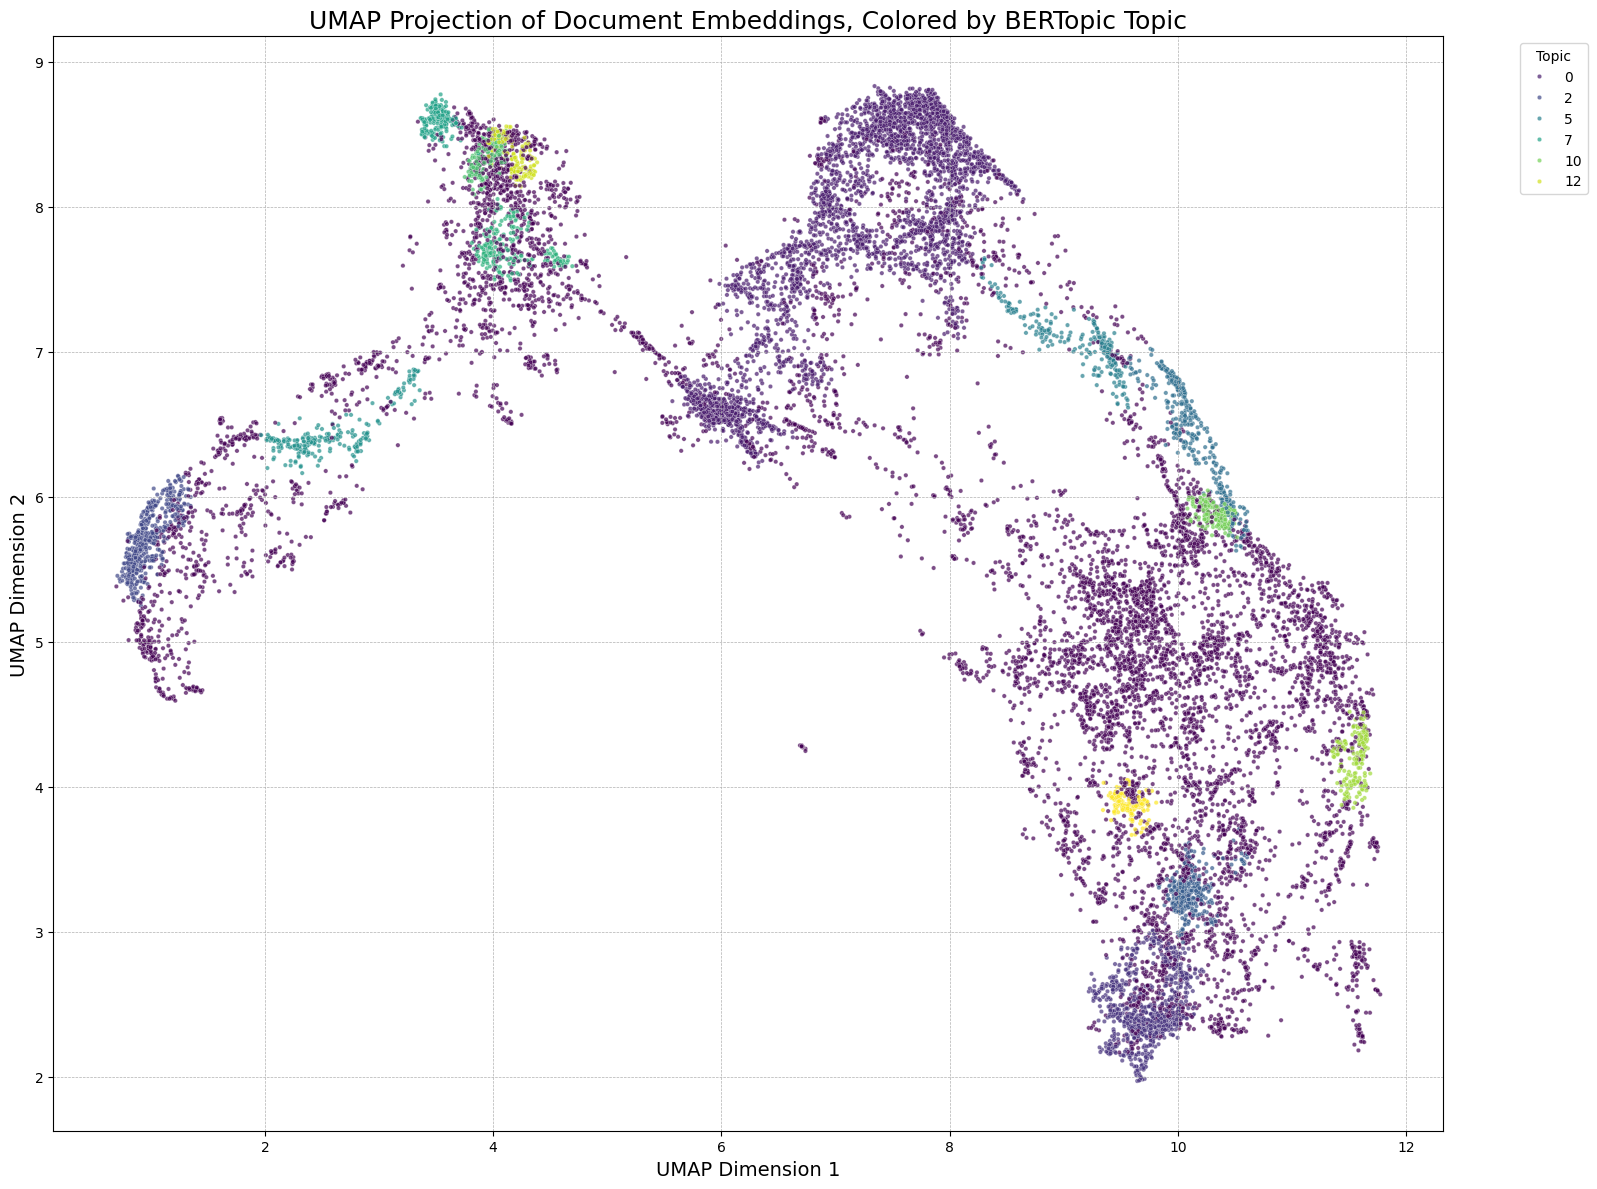

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the best model from Pipeline 3 is used
if 'best_model_p3_improved' in globals() and best_model_p3_improved is not None:
    # Get the topic assignments for each document
    # Using .topics_ attribute is a stable way to get assignments after fitting
    topics_p3_best = best_model_p3_improved.topics_
    df['bertopic_pipeline3_best_cluster'] = topics_p3_best

    # Get the UMAP embeddings (which has 5 dimensions)
    umap_embeddings = best_model_p3_improved.umap_model.embedding_

    # --- FIX IS HERE ---
    # Create a DataFrame with all 5 UMAP components for plotting
    # We will still plot only the first two (UMAP1 and UMAP2)
    umap_df = pd.DataFrame(umap_embeddings, columns=[f'UMAP{i+1}' for i in range(umap_embeddings.shape[1])])
    umap_df['Topic'] = topics_p3_best

    # Create a subset of topics to visualize for clarity, e.g., top 15 topics + noise
    top_topics = umap_df['Topic'].value_counts().nlargest(15).index
    plot_df = umap_df[umap_df['Topic'].isin(top_topics) | (umap_df['Topic'] == -1)]


    # Plot the UMAP embeddings
    plt.figure(figsize=(16, 12))
    sns.scatterplot(
        data=plot_df,
        x='UMAP1',
        y='UMAP2',
        hue='Topic',
        palette='viridis', # You can try other palettes like 'tab20' for more distinct colors
        s=10,
        alpha=0.7
    )
    plt.title('UMAP Projection of Document Embeddings, Colored by BERTopic Topic', fontsize=18)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("The best BERTopic model was not found. Please run the improvement cells first.")

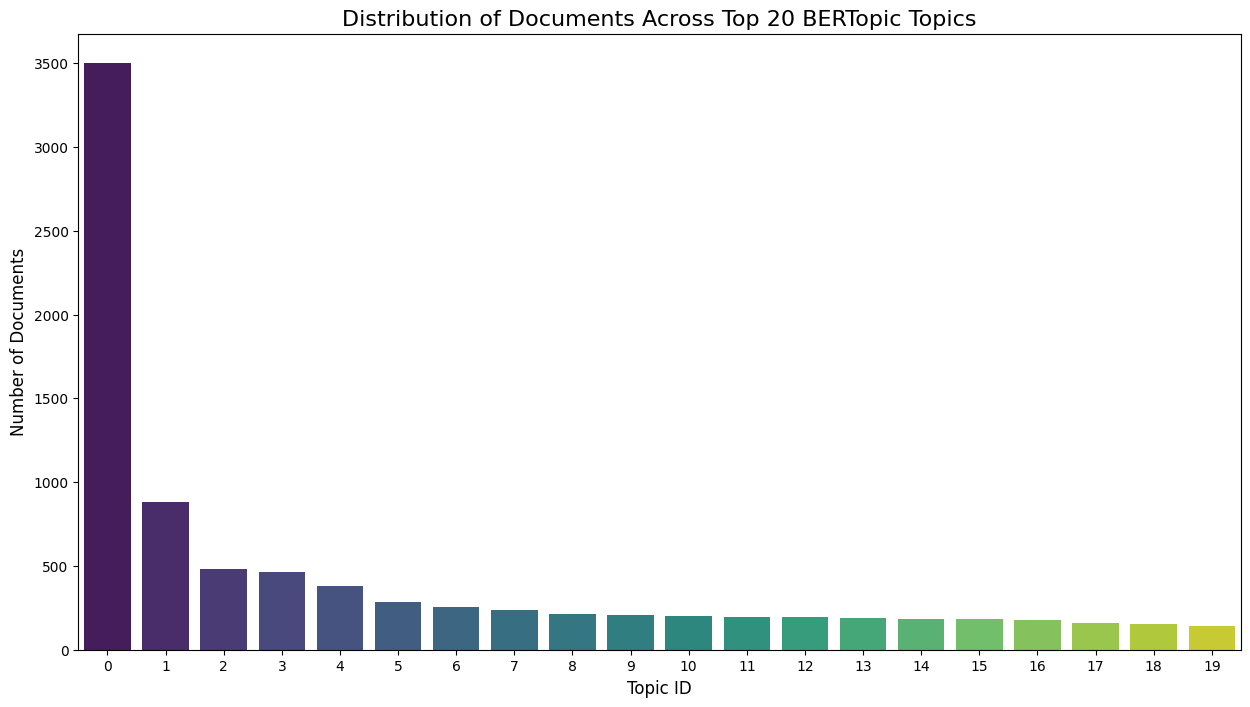

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'best_model_p3_improved' in globals() and best_model_p3_improved is not None:
    # Get topic information
    topic_info_p3_best = best_model_p3_improved.get_topic_info()

    # Exclude the outlier topic (-1)
    actual_topics_info_p3_best = topic_info_p3_best[topic_info_p3_best.Topic != -1]

    # Create the bar chart
    plt.figure(figsize=(15, 8))
    sns.barplot(
        data=actual_topics_info_p3_best.head(20),  # Display top 20 topics
        x='Topic',
        y='Count',
        palette='viridis'
    )
    plt.title('Distribution of Documents Across Top 20 BERTopic Topics', fontsize=16)
    plt.xlabel('Topic ID', fontsize=12)
    plt.ylabel('Number of Documents', fontsize=12)
    plt.show()
else:
    print("The best BERTopic model was not found. Please run the improvement cells first.")

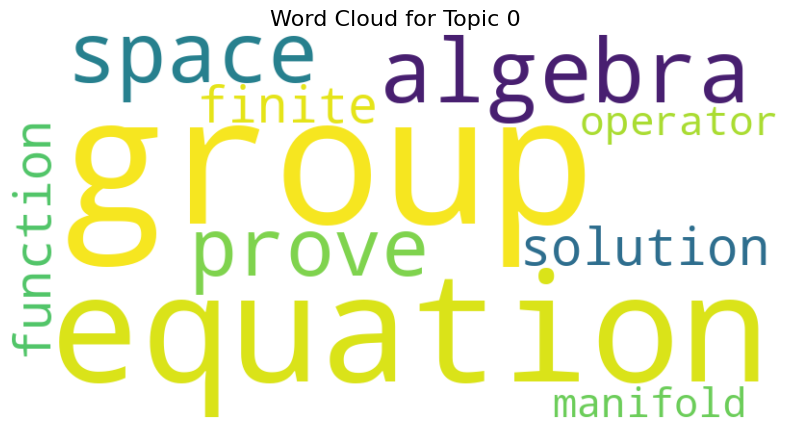

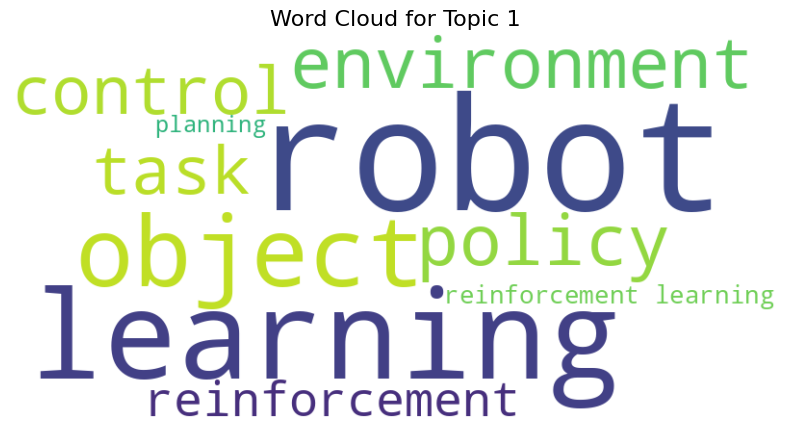

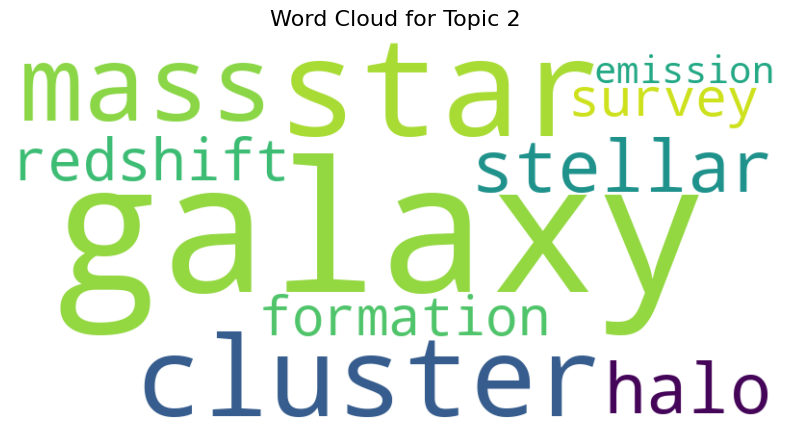

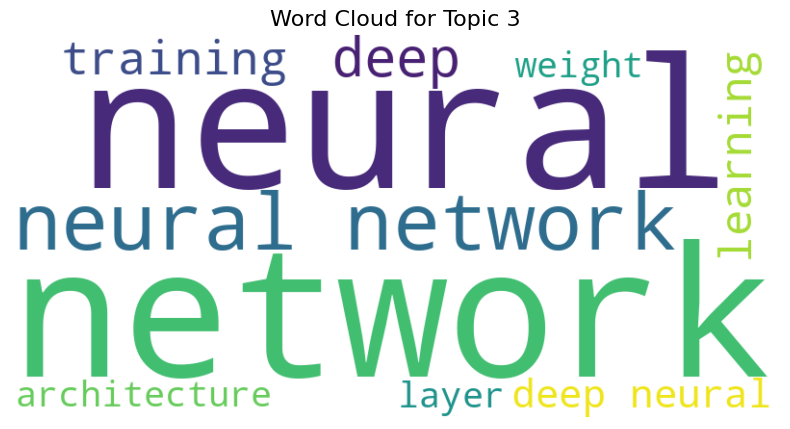

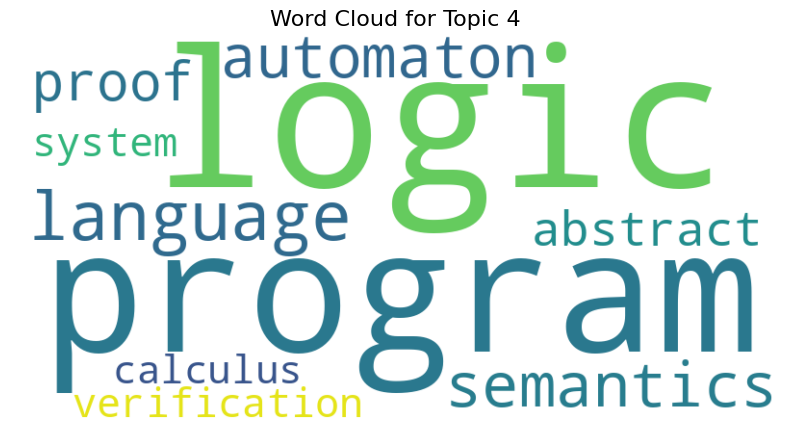

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

if 'best_model_p3_improved' in globals() and best_model_p3_improved is not None:
    # Get the top topics
    top_topics = best_model_p3_improved.get_topic_info()[1:6]  # Get top 5 topics (excluding -1)

    for index, row in top_topics.iterrows():
        topic_id = row['Topic']
        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white'
        ).generate_from_frequencies(dict(best_model_p3_improved.get_topic(topic_id)))

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Topic {topic_id}', fontsize=16)
        plt.show()
else:
    print("The best BERTopic model was not found. Please run the improvement cells first.")